# The macroscopic current in response to a concentration jump or pulse

In [1]:
import numpy as np
from numpy import linalg as nplin

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)

### The 5 state model used in CH82 for numerical example

Names of subsets: A- open states, F- shut states, B- short-lived shut states (within burst), C- long-lived states

##### Number of states:

In [3]:
k, kA, kB, kC, kF = 5, 2, 2, 1, 3

###### Values for rate constants:

Gating:

In [4]:
b1, a1, b2, a2 = 15., 3000., 15000., 500.

Binding:

In [5]:
kd1, ka1, kd2, ka2, ka2x = 2000., 5e7, 2000., 5e8, 5e8

Get dissociation rate from open state by microscopic reversibility

In [6]:
kd2x = (ka2x * a2 * kd2 * b1) / (b2 * ka2 * a1)

In [7]:
kd2x

0.3333333333333333

Define concentration (eg 10 microM)

In [8]:
c = 10e-6

Define Q matrix:

In [9]:
def Qmat(c):
    return np.array([[ -(ka2x*c + a1),         ka2x*c,              0,                  a1,           0 ], 
                     [      2. * kd2x, -(2*kd2x + a2),             a2,                   0,           0 ],  
                     [              0,             b2, -(b2 + 2.*kd2),              2.*kd2,           0 ],  
                     [             b1,              0,          ka2*c, -(b1 + ka2*c + kd1),         kd1 ],  
                     [              0,              0,              0,            2.*ka1*c, -(2.*ka1*c) ] ])

In [10]:
Q = Qmat(c)

In [11]:
Q

array([[ -8000.      ,   5000.      ,      0.      ,   3000.      ,
             0.      ],
       [     0.666667,   -500.666667,    500.      ,      0.      ,
             0.      ],
       [     0.      ,  15000.      , -19000.      ,   4000.      ,
             0.      ],
       [    15.      ,      0.      ,   5000.      ,  -7015.      ,
          2000.      ],
       [     0.      ,      0.      ,      0.      ,   1000.      ,
         -1000.      ]])

Define some useful unit column vectors:

In [12]:
u, uA, uF = np.ones((k,1)), np.ones((kA,1)), np.ones((kF,1)) 

Q rows sum to zero

In [13]:
np.dot(Q, u)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

One eigenvalue of Q is zero

In [14]:
eigvals, M = nplin.eig(Q)

In [15]:
eigvals

array([-20827.987156,  -8017.886104,  -6001.630678,     -0.      ,
         -668.162729])

## Calculation of equilibrium occupancies

$\textbf{p}(t)=[p_1(t), p_2(t), ..., p_k(t)]$

$\dfrac{d}{dt}p(t)=p(t) \cdot Q$

In the steady state occupancies do not change with time then

$0=p(\infty) \cdot Q$

##### Solution by adding a column of ones

In [16]:
S = np.concatenate((Q, u), 1)

In [17]:
S

array([[ -8000.      ,   5000.      ,      0.      ,   3000.      ,
             0.      ,      1.      ],
       [     0.666667,   -500.666667,    500.      ,      0.      ,
             0.      ,      1.      ],
       [     0.      ,  15000.      , -19000.      ,   4000.      ,
             0.      ,      1.      ],
       [    15.      ,      0.      ,   5000.      ,  -7015.      ,
          2000.      ,      1.      ],
       [     0.      ,      0.      ,      0.      ,   1000.      ,
         -1000.      ,      1.      ]])

$p(\infty)=u^T \cdot (S \cdot S^T)^{-1}$

In [18]:
pinf = np.dot(u.transpose(), nplin.inv((np.dot(S,S.transpose()))))[0]

In [19]:
pinf

array([0.00012 , 0.898096, 0.029937, 0.023949, 0.047898])

## The macroscopic response to a jump in concentration

The basic result is   $p(t)=p(0) \cdot e^{Q \cdot t}$

###### Spectral expansion

To evaluate the matrix exponential we use the spectral expansion.

The easy bit is the time constants. Get eigenvalues and eigenvectors of $-Q$:

In [20]:
eigvals, M = nplin.eig(-Q)
sorted_indices = eigvals.real.argsort()
eigvals = eigvals[sorted_indices]
M = M[:,sorted_indices]

In [21]:
tau = 1000 / eigvals # time constants in milliseconds

In [22]:
tau

array([1.167307e+15, 1.496641e+00, 1.666214e-01, 1.247212e-01,
       4.801232e-02])

Note that 'zero' eigenvalue is not excatly zero because of rounding errors in the calculations, but the corresponding time constant is

In [23]:
tau[0] / (1000 * 60 * 60 * 24 * 365) # time constant in years!

37015.06197088238

No calculate the spectral expansion matrices, $A_m$, by multiplying m-th column of $M$ by m-th row of $N=M^{-1}$.
The m-th column of $M$ (the m-th column eigenvector) is denoted in Numpy as M[:, m].
The m-th row of $N$ (the m-th row eigenvector) is denoted in Numpy as N[m, :].
All column eigenvectors can be found as the columns of a matrix $M$ found earlier. Eg first column vector:

In [24]:
M[:, 0]

array([-0.447214, -0.447214, -0.447214, -0.447214, -0.447214])

In [25]:
N = nplin.inv(M)

In [26]:
A = np.zeros((k, k, k))
for i in range(k):
        A[i] = np.dot(M[:, i].reshape(k, 1), N[i].reshape(1, k))
#A = A[sorted_indices]

Do some checks. The spectral matrices add up to unit matrix.

In [27]:
A.sum(axis=0)

array([[ 1.,  0., -0.,  0., -0.],
       [-0.,  1.,  0., -0.,  0.],
       [-0., -0.,  1., -0.,  0.],
       [ 0.,  0., -0.,  1., -0.],
       [ 0.,  0.,  0.,  0.,  1.]])

Product of two different spectral matrices equals = 0, eg $A_0 \cdot A_1=0$

In [28]:
np.dot(A[0], A[1])

array([[-0.,  0., -0., -0., -0.],
       [-0.,  0., -0., -0., -0.],
       [-0.,  0., -0., -0., -0.],
       [-0.,  0., -0., -0., -0.],
       [-0.,  0., -0., -0., -0.]])

In [29]:
A[0]

array([[0.00012 , 0.898096, 0.029937, 0.023949, 0.047898],
       [0.00012 , 0.898096, 0.029937, 0.023949, 0.047898],
       [0.00012 , 0.898096, 0.029937, 0.023949, 0.047898],
       [0.00012 , 0.898096, 0.029937, 0.023949, 0.047898],
       [0.00012 , 0.898096, 0.029937, 0.023949, 0.047898]])

Compare spectral matrix $A_0$, corresponding to zero eigenvalue, with the equilibrium occupancies found above.

In [30]:
pinf

array([0.00012 , 0.898096, 0.029937, 0.023949, 0.047898])

Each column of $A_0$ consists of identical elements, the m-th column being the equilibrium occupancy of state m. This means that premultiplication of $A_0$ by any vector whose elements dum to 1 gives $p(\infty)$.
We can now use this to evaluate $p(t)=p(0) \cdot e^{Q \cdot t}$

##### Define the initial vector

If we consider a jump from zero concentration to concentration c, the receptor is initially all in state 5

In [31]:
p0 = [0., 0., 0., 0., 1.]

The spectral expansion of $e^{Q \cdot t}$ is

$e^{Q \cdot t}=\sum\limits_{m=0}^{k-1} A_m \cdot e^{-\lambda_m \cdot t}$

but as noted above, $p(0) \cdot A_0=p(\infty)$

In [32]:
np.dot(p0, A[0])

array([0.00012 , 0.898096, 0.029937, 0.023949, 0.047898])

##### Define $p(t)$

$p(t)=p(\infty)+p(0) \cdot \sum\limits_{m=1}^{k-1}(A_m \cdot e^{-\lambda_m \cdot t})$

Note that there are k-1 components.

In [33]:
def p(t):
    At = np.zeros((eigvals.size, eigvals.size))
    for i in range(1, eigvals.size):
        At += A[i] * np.exp(-t / tau[i])
    return pinf + np.dot(p0, At)

In [34]:
p(1)

array([0.000222, 0.36327 , 0.035736, 0.098845, 0.501927])

##### Plot $P_{open}$ and occupancies of open states

In [35]:
t = np.linspace(0.0, 6.0, num=256)
pt = []
for ti in t:
    pt.append(p(ti))
pt = np.array(pt)
Popen = pt[:,0] + pt[:,1]

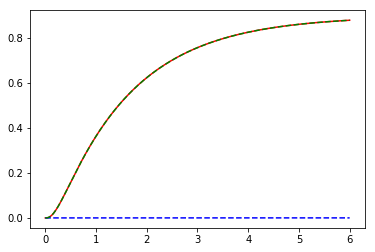

In [36]:
plt.plot(t, Popen, 'r-', t, pt[:,0], 'b--', t, pt[:,1], 'g--')

##### Plot the current

$I(t)=N \cdot V \cdot p(t) \cdot \gamma$ , where $N$- number of channels, $V$- voltage (V), $\gamma$- conductance (pS)

Define a column vector $\gamma$ that contains conductances (pS)

In [37]:
gamma = np.zeros((k,1))
gamma[0], gamma[1] = 60, 60

In [38]:
gamma

array([[60.],
       [60.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [39]:
N, V = 1, -0.1

In [40]:
def I(t):
    return N * V * np.dot(p(t), gamma)

In [41]:
It = []
for ti in t:
    It.append(I(ti))
It = np.array(It)

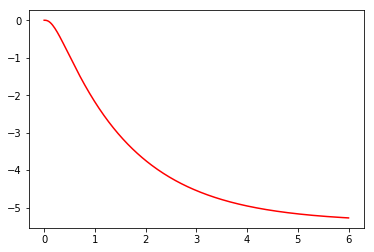

In [42]:
plt.plot(t, It, 'r-')



#### Calculate amplitudes for each exponential component

Note that exactly the same time constants describe the time course of occupancy for all five states. The only thing that varies from one state to another is the amplitude of the components.

$w_{m,j}$ is amplitude of m th component in occupancy for state j in the entirely scalar representation of the time course

$p_j (t)=p_j (\infty)+ \sum\limits_{m=1}^{k-1}[p(0)_{0,i} \cdot (A_m)_{i,j}]$

Now find weghted components:

In [43]:
def w(k, A, p):
    w = np.zeros((k, k))
    for n in range (k):
        w[n, :] = np.dot(p, A[n, :, :])
    return w

In [44]:
w(k, A, p0)[1,1]

-1.044020242694743